In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, hinge_loss, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


df_results = pd.read_csv('results.csv')
df_results.drop(columns=['match_winner', 'event_id', 'map_wins_1', 'map_wins_2'], inplace=True)
df_results = df_results.loc[df_results['_map'] != 'Default']
df_results = df_results.loc[df_results['date'] > '2018-01-01']
df_results = df_results.loc[(df_results['rank_1'] <= 100) & (df_results['rank_2'] <= 100)]
df_results = df_results.reset_index()
df_results.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16400 entries, 0 to 16399
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        16400 non-null  int64 
 1   date         16400 non-null  object
 2   team_1       16400 non-null  object
 3   team_2       16400 non-null  object
 4   _map         16400 non-null  object
 5   result_1     16400 non-null  int64 
 6   result_2     16400 non-null  int64 
 7   map_winner   16400 non-null  int64 
 8   starting_ct  16400 non-null  int64 
 9   ct_1         16400 non-null  int64 
 10  t_2          16400 non-null  int64 
 11  t_1          16400 non-null  int64 
 12  ct_2         16400 non-null  int64 
 13  match_id     16400 non-null  int64 
 14  rank_1       16400 non-null  int64 
 15  rank_2       16400 non-null  int64 
dtypes: int64(12), object(4)
memory usage: 2.0+ MB


In [48]:
df_results['1st_half_winner'] = df_results.apply(lambda df: 1 if (df['starting_ct'] == 1 and df['ct_1'] > df['t_2']) or (df['starting_ct'] == 2 and df['t_1'] > df['ct_2']) else 2, axis = 1)
df_results['1st_half_diff'] = df_results.apply(lambda df: (df['ct_1'] - df['t_2']) if (df['starting_ct'] == 1) else (df['t_1'] - df['ct_2']), axis = 1)
df_results['rank_diff'] = (df_results['rank_2'] - df_results['rank_1'])
df_results['map_diff'] = df_results['result_1'] - df_results['result_2']

maps = df_results['_map'].unique()
ct_wins_maps = {}
ct = {}
for _map in maps:
    ct_r = df_results[df_results['_map'] == _map]['ct_1'].sum() + df_results[df_results['_map'] == _map]['ct_2'].sum()
    t_r = df_results[df_results['_map'] == _map]['t_1'].sum() + df_results[df_results['_map'] == _map]['t_2'].sum()
    ct_wins_maps[_map] = ct_r/(t_r + ct_r)
    
    ct_half_won = df_results[(df_results['_map'] == _map) & ((df_results['ct_1'] > df_results['t_2']))].shape[0]
    ct_half_won += df_results[(df_results['_map'] == _map) & ((df_results['ct_2'] > df_results['t_1']))].shape[0]
    ct_half_won += df_results[(df_results['_map'] == _map) & ((df_results['ct_2'] > df_results['t_1']) & ((df_results['ct_1'] > df_results['t_2'])))].shape[0]
    n_halfs = df_results[(df_results['_map'] == _map)].shape[0] * 2
    ct[_map] = ct_half_won/n_halfs
    
    
df_results['map_ct_win_percent'] = df_results.apply(lambda row: ct[row['_map']], axis=1)

corr_df = df_results.drop(columns=['date'])

corr_df['_map'] = corr_df['_map'].astype('category').cat.codes

team_to_num = {}
team_to_comebacks = {}
team_to_secured = {}
for index, team in enumerate(pd.concat([corr_df['team_1'], corr_df['team_2']]).unique()):
    team_to_num[team] = index
    comeback_games = corr_df[(corr_df['team_1'] == team) & (corr_df['1st_half_diff'] <= -1)].shape[0] + \
        corr_df[(corr_df['team_2'] == team) & (corr_df['1st_half_diff'] >= 1)].shape[0]
    
    secured_games = corr_df[(corr_df['team_1'] == team) & (corr_df['1st_half_diff'] >= 1)].shape[0] + \
        corr_df[(corr_df['team_2'] == team) & (corr_df['1st_half_diff'] <= -1)].shape[0]
    
    comebacks = corr_df[(corr_df['team_1'] == team) & (corr_df['1st_half_diff'] <= -1) & (corr_df['map_winner'] == 1)].shape[0] + \
        corr_df[(corr_df['team_2'] == team) & (corr_df['1st_half_diff'] >= 1) & (corr_df['map_winner'] == 2)].shape[0]

    secured = corr_df[(corr_df['team_1'] == team) & (corr_df['1st_half_diff'] >= 1) & (corr_df['map_winner'] == 1)].shape[0] + \
        corr_df[(corr_df['team_2'] == team) & (corr_df['1st_half_diff'] <= -1) & (corr_df['map_winner'] == 2)].shape[0]

    comeback_percent = comebacks / comeback_games if comeback_games != 0 else 0
    secured_percent = secured / secured_games if secured_games != 0 else 0

    team_to_comebacks[team] = comeback_percent
    team_to_secured[team] = secured_percent
    #print(secured_percent)
    


corr_df['1st_loser_comeback'] = corr_df.apply(lambda row: team_to_comebacks[row['team_1']] if row['1st_half_winner'] == 2 else team_to_comebacks[row['team_2']], axis=1)
corr_df['1st_winner_secure'] = corr_df.apply(lambda row: team_to_secured[row['team_1']] if row['1st_half_winner'] == 1 else team_to_secured[row['team_2']], axis=1)
corr_df['team_1_comeback'] = corr_df['team_1'].apply(lambda row: team_to_comebacks[row])
corr_df['team_2_comeback'] = corr_df['team_2'].apply(lambda row: team_to_comebacks[row])
corr_df['team_1_secured'] = corr_df['team_1'].apply(lambda row: team_to_secured[row])
corr_df['team_2_secured'] = corr_df['team_2'].apply(lambda row: team_to_secured[row])
corr_df['team_1'] = corr_df['team_1'].apply(lambda row: team_to_num[row])
corr_df['team_2'] = corr_df['team_2'].apply(lambda row: team_to_num[row])


df_results['1st_loser_comeback'] = df_results.apply(lambda row: team_to_comebacks[row['team_1']] if row['1st_half_winner'] == 2 else team_to_comebacks[row['team_2']], axis=1)
df_results['1st_winner_secure'] = df_results.apply(lambda row: team_to_secured[row['team_1']] if row['1st_half_winner'] == 1 else team_to_secured[row['team_2']], axis=1)
df_results['team_1_comeback'] = df_results['team_1'].apply(lambda row: team_to_comebacks[row])
df_results['team_2_comeback'] = df_results['team_2'].apply(lambda row: team_to_comebacks[row])
df_results['team_1_secured'] = df_results['team_1'].apply(lambda row: team_to_secured[row])
df_results['team_2_secured'] = df_results['team_2'].apply(lambda row: team_to_secured[row])
df_results['team_1'] = df_results['team_1'].apply(lambda row: team_to_num[row])
df_results['team_2'] = df_results['team_2'].apply(lambda row: team_to_num[row])

df_results.drop(columns=['result_1', 'result_2', 'date', 'ct_1', 'ct_2', 't_2', 't_1']).head(5)


,index,team_1,team_2,_map,map_winner,starting_ct,match_id,rank_1,rank_2,1st_half_winner,1st_half_diff,rank_diff,map_diff,map_ct_win_percent,1st_loser_comeback,1st_winner_secure,team_1_comeback,team_2_comeback,team_1_secured,team_2_secured
0,0,0,147,Dust2,2,2,2340454,62,63,2,-15,1,-16,0.531675,0.333333,0.716418,0.333333,0.238806,1.000000,0.716418
1,1,0,147,Inferno,2,2,2340454,62,63,2,-5,1,-3,0.543625,0.333333,0.716418,0.333333,0.238806,1.000000,0.716418
2,3,1,20,Inferno,2,2,2340453,61,38,2,-1,-23,-9,0.543625,0.230769,0.829787,0.230769,0.250000,0.466667,0.829787
3,4,1,20,Vertigo,2,2,2340453,61,38,2,-7,-23,-8,0.531325,0.230769,0.829787,0.230769,0.250000,0.466667,0.829787
4,5,2,18,Overpass,2,2,2340456,71,41,2,-5,-30,-3,0.676056,0.243094,0.772727,0.243094,0.169231,0.711765,0.772727


In [49]:
#testing
#fig = plt.figure()
#axis = fig.add_subplot(1, 1, 1)

#axis.scatter(df_results[df_results['map_winner'] == 2]['1st_half_diff'], df_results[df_results['map_winner'] == 2]['rank_diff'], s=10, c='b', marker="s", label='first', alpha=0.3)
#axis.scatter(df_results[df_results['map_winner'] == 1]['1st_half_diff'], df_results[df_results['map_winner'] == 1]['rank_diff'], s=10, c='r', marker="o", label='second', alpha=0.3)


In [50]:
# , 'team_1', 'team_2', 'team_2_comeback', '1st_loser_comeback', '1st_winner_secure', 'team_1_comeback', 'team_2_secured', 'team_1_secured'
X = df_results[['1st_half_diff', 'rank_diff', 'starting_ct', 'map_ct_win_percent']].to_numpy().reshape(-1, 4)
y = df_results['map_winner'].to_numpy()
#X = corr_df.drop(columns=['map_winner', 'map_diff', 'result_1', 'result_2', 't_1', 't_2', 'ct_2', 'ct_1']).to_numpy().reshape(-1, 12)



X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
X_train_, X_val_, y_train, y_val = train_test_split(X_train_, y_train, test_size=0.25, random_state=45)

scale = StandardScaler()
X_train = scale.fit_transform(X_train_)
X_test = scale.transform(X_test_)
X_val = scale.transform(X_val_)


model = LogisticRegression(penalty="l2", C=1000)
model_2 = SVC(C=10, kernel='rbf')

# ---- FIT MODELS ----
model.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# ---- PREDICT ----
y_pred_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
y_pred_val = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
y_pred_train_2 = model_2.predict(X_train)
accuracy_train_2 = accuracy_score(y_train, y_pred_train_2)
y_pred_test_2 = model_2.predict(X_test)
y_pred_val_2 = model_2.predict(X_val)
accuracy_val_2 = accuracy_score(y_val, y_pred_val_2)

# ---- Errors ----
train_err = log_loss(y_train, model.predict_proba(X_train))
val_err = log_loss(y_val, model.predict_proba(X_val))
test_err = log_loss(y_test, model.predict_proba(X_test))

train_err_2 = hinge_loss(y_train, y_pred_train_2)
val_err_2 = hinge_loss(y_val, y_pred_val_2)
test_err_2 = hinge_loss(y_test, y_pred_test_2)

conf_mat = confusion_matrix(y_val, y_pred_val)
conf_mat_2 = confusion_matrix(y_val, y_pred_val_2)
print("---- LOGISTIC REGRESSION ----")
print(f"Training accuracy logRes: {accuracy_train}")
print(f"Validation accuracy logRes: {accuracy_val}")

print(f"Training error logLoss: {train_err}")
print(f"Validation error logLoss: {val_err}")
print(f"Test error logLoss: {test_err}")
print(f"confusion matrix\n{conf_mat}")
print("\n")
print("---- SVC ----")
print(f"Training accuracy SVC: {accuracy_train_2}")
print(f"Validation accuracy SVC: {accuracy_val_2}")

print(f"Training error hingeLoss: {train_err_2}")
print(f"Validation error hingeLoss: {val_err_2}")
print(f"Test error hingeLoss: {test_err_2}")
print(f"confusion matrix\n{conf_mat_2}")




---- LOGISTIC REGRESSION ----
Training accuracy logRes: 0.7724593495934959
Validation accuracy logRes: 0.7701219512195122
Training error logLoss: 0.47128576867447647
Validation error logLoss: 0.47321091159625306
Test error logLoss: 0.47928018783664683
confusion matrix
[[1374  377]
 [ 377 1152]]


---- SVC ----
Training accuracy SVC: 0.7801829268292683
Validation accuracy SVC: 0.774390243902439
Training error hingeLoss: 1.1589430894308943
Validation error hingeLoss: 1.1817073170731707
Test error hingeLoss: 1.1655487804878049
confusion matrix
[[1377  374]
 [ 366 1163]]


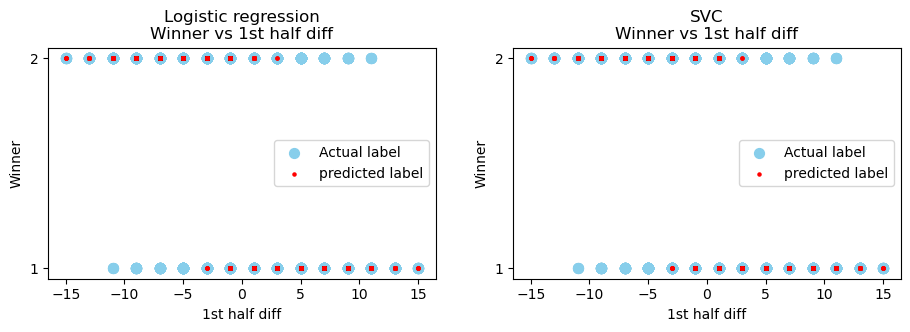

In [51]:

fig, ax = plt.subplots(1, 2, figsize=(11,3))
ax[0].set_xlabel("1st half diff")
ax[0].set_yticks([1, 2])
ax[0].set_ylabel('Winner')
ax[0].set_title("Logistic regression\nWinner vs 1st half diff")
ax[0].scatter([x[0] for x in X_val_], y_val,s=50,c="skyblue",label="Actual label")
ax[0].scatter([x[0] for x in X_val_], y_pred_val,color='r',s=5,label='predicted label') 
ax[0].legend()
ax[1].set_xlabel("1st half diff")
ax[1].set_yticks([1, 2])
ax[1].set_ylabel('Winner')
ax[1].set_title("SVC\nWinner vs 1st half diff")
ax[1].scatter([x[0] for x in X_val_], y_val,s=50,c="skyblue",label="Actual label")
ax[1].scatter([x[0] for x in X_val_], y_pred_val_2,color='r',s=5,label='predicted label') 
ax[1].legend()
plt.show()


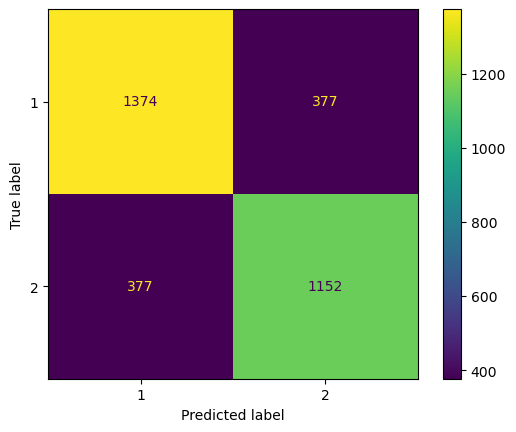

In [52]:

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                               display_labels=model.classes_)
disp.plot()

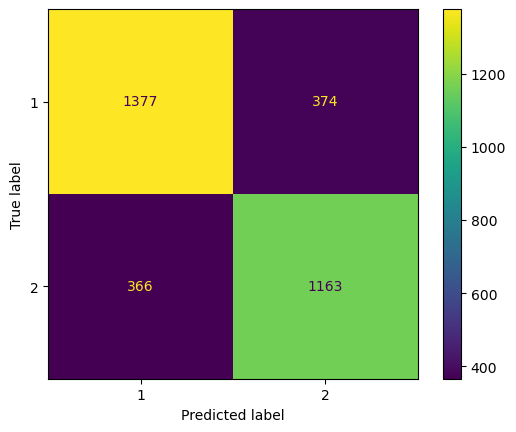

In [53]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_2,
                               display_labels=model_2.classes_)
disp.plot()